# Standard pre-processing steps (already seen in previous notebooks)

In [ ]:
#install and import required libraries
!pip install transformers
!pip install -U sentence-transformers
!pip install datasets
#install nltk emoji library to be used with normalizeTweet()
!pip install nltk emoji==0.6.0
!pip install evaluate
!pip install scikit-learn-extra



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 40.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.7 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=d7b16992a61d02fa3b17c29e3b207b2c9fdb61cbf7a643559c2310e31024846d
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers
Looking in indexes: https://pypi.o

In [ ]:
import pandas as pd
import numpy as np
import torch

import transformers
from datasets import Dataset
from datasets.table import Table
import pyarrow as pa
import pyarrow.dataset as ds
from datasets import Dataset , DatasetDict

from evaluate import load
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.model_selection import StratifiedKFold, ParameterGrid,  GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


metric = load('glue','sst2')



import logging
logging.basicConfig(level=logging.ERROR)

from TweetNormalize import normalizeTweet

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize, pos_tag
from nltk.stem.wordnet import WordNetLemmatizer

import spacy
import re
nlp = spacy.load('en_core_web_sm')

stopword_list = stopwords.words('english')

doc_counter = 0
def reset_counter():
  global doc_counter
  doc_counter = 0

def increase_counter():
  global doc_counter
  doc_counter += 1
  if doc_counter % 100 == 0:
    print(doc_counter)

def spacy_nlp_tokenizer(text):
    increase_counter()

    # substituting all space characters with a single space
    text = re.sub('\s+', ' ', text)

    # we use spacy for main nlp tasks
    doc = nlp(text)
    # lemmatized tokens, skipping stopwords
    lemmas = ['LEMMA_'+token.lemma_ for token in doc if not token.is_stop]
    # entity_types
    entity_types = ['NER_'+token.ent_type_ for token in doc if token.ent_type_]

    # in case an entity linker is available, we can use it do put actual entities as
    # features, e.g. Queen Elizabeth, Elizabeth II, Her Majesty -> KB2912
    # see https://spacy.io/usage/training#entity-linker
    # entities = ['ENT_'+token.ent_kb_id_ for token in doc if token.ent_kb_id_]

    # we use a simple nltk function to create ngrams
    lemma_bigrams = ['BI_'+p1+'_'+p2 for p1,p2 in nltk.ngrams(lemmas,2)]
    lemma_trigrams = ['TRI_'+p1+'_'+p2+'_'+p3 for p1,p2,p3 in nltk.ngrams(lemmas,3)]

    all_tokens = list()
    all_tokens.extend(lemmas)
    all_tokens.extend(lemma_bigrams)
    all_tokens.extend(lemma_trigrams)
    all_tokens.extend(entity_types)
    return all_tokens

from EDA_AUG import eda_4

# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print('Is GPU available for usage?', torch.cuda.is_available())
print("How many devices available for 'cuda'?", torch.cuda.device_count())







from matplotlib import pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Is GPU available for usage? False
How many devices available for 'cuda'? 0


/content/EDA_AUG.py:177: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  words = [word for word in words if word is not '']
/content/EDA_AUG.py:285: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  words = [word for word in words if word is not '']


In [ ]:
#import datasets
df_en_train = pd.read_csv("/content/data_sets/corrected_df.csv", sep=',', header=0)
df_en_test = pd.read_csv("/content/data_sets/en_testing_labeled.tsv", sep='\t', header=0)

df_en_train.drop(df_en_train[df_en_train['misogyny_category'] == '0'].index, inplace = True)
df_en_test.drop(df_en_test[df_en_test['misogyny_category'] == '0'].index, inplace = True)


x_train_multi = [normalizeTweet(i) for i in df_en_train['text']]
y_train_multi = [i for i in df_en_train['misogyny_category']]
x_test_multi = [normalizeTweet(i) for i in df_en_test['text']]
y_test_multi = [i for i in df_en_test['misogyny_category']]

In [ ]:
#define a label encoding for multi_class categories
ordered_labels = sorted(list(set(y_train_multi)))
label_dict = {}
k=0
for i in ordered_labels:
  label_dict[i] = k
  k+=1

y_train_multi = [label_dict[i] for i in df_en_train['misogyny_category']]
y_test_multi = [label_dict[i] for i in df_en_test['misogyny_category']]

In [ ]:
label_dict

{'derailing': 0,
 'discredit': 1,
 'dominance': 2,
 'sexual_harassment': 3,
 'stereotype': 4}

In [ ]:
#create dataframes from the normalized tweets
df_train_multi = pd.DataFrame(data = {'Text': x_train_multi, 'label': y_train_multi},)
df_test_multi = pd.DataFrame(data = {'Text': x_test_multi, 'label': y_test_multi},)

In [ ]:
set(df_train_multi['label'])

{0, 1, 2, 3, 4}

In [ ]:
df_train_multi_three = df_train_multi
df_test_multi_three = df_test_multi

df_train_multi_three

df_train_multi_three = df_train_multi_three[df_train_multi_three.label != label_dict['derailing']]
df_test_multi_three = df_test_multi_three[df_test_multi_three.label != label_dict['derailing']]

df_train_multi_three.label.replace( [label_dict['dominance']],  [ label_dict['stereotype']]   ,  inplace=True)
df_test_multi_three.label.replace( [label_dict['dominance']],  [ label_dict['stereotype']]   ,  inplace=True)

df_train_multi_three = df_train_multi_three.reset_index()
df_test_multi_three = df_test_multi_three.reset_index()

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [ ]:
set(df_test_multi_three['label'])


{1, 3, 4}

In [ ]:
df_train_multi_three['label'].replace([1,3,4], [0,1,2], inplace = True)
df_test_multi_three['label'].replace([1,3,4], [0,1,2], inplace = True)



In [ ]:
set(df_test_multi_three['label'])
display(df_train_multi_three.shape)
display(df_train_multi_three['label'].value_counts())


(1637, 3)

0    982
1    334
2    321
Name: label, dtype: int64

In [ ]:
df_train_multi_three

,index,Text,label
0,0,Please tell me why the bitch next to me in the...,2
1,1,@USER @USER Bitch shut the fuck up,2
2,2,"@USER Dear cunt , please shut the fuck up .",2
3,3,RT @USER : Pls shut the fuck up bitch,2
4,4,"RT @USER : "" when u gonna get your license "" S...",2
...,...,...,...
1632,1722,@USER @USER @USER @USER This ugly bitch has a ...,0
1633,1723,@USER Your lady probably is a bitch though . M...,0
1634,1724,"Women are bitches . 1 time , this bitch in BAL...",0
1635,1725,Any woman that likes me is a bitch . All women...,0


In [ ]:
#perform cross-validation with data-augmentation and see if it performs any better

def enlarge_df(df, label, limit : float):
  df_new = df
  limit = int(len(df[df['label'] == label]['Text']) * limit)

  to_add = []

  for string in df[df['label'] == label]['Text']:
    k = eda_4(sentence = string, alpha_sr = 0.2, alpha_ri = 0.0, alpha_rs=0.2, num_aug = 10) #generate 10 instances
    for j in k:
      if len(to_add) == limit:
        print(len(to_add))
        return df_new
      df_new = df_new.append({'Text': j , 'label' : label}, ignore_index = True)
      to_add.append(j)
      
  return df_new     

In [ ]:
for label in [0,1,2]:
    if label == 0:
        continue   
    new = enlarge_df(df_train_multi_three, label, 0.5)
    df_train_multi_three = new
    
df_train_multi_three['label'].value_counts()

167
160


0    982
1    501
2    481
Name: label, dtype: int64

In [ ]:
def support_tokenizer(df, tokenizer, max_length = 256):
  
  input_ids = []
  token_type_ids = []
  attention_mask = []

  for sentence in df['Text']:
              #for each sentence, perform a tokenization compatible with bert models
              #getting input_ids, token_type_ids and attention_mask
              sent_tok = tokenizer.encode_plus(sentence, padding="max_length", \
                                              truncation=True, 
                                              add_special_tokens=True,
                                              max_length=256,
                                              pad_to_max_length=True,
                                              return_token_type_ids=True)
              

              input_ids.append(sent_tok['input_ids'])
              token_type_ids.append(sent_tok['token_type_ids'])
              attention_mask.append(sent_tok['attention_mask'])


  #crete a dataframe with the original information + the new tokenized data
  tok_df = pd.DataFrame({'Text': df['Text'], 'label': df['label'],
                         'input_ids': input_ids,'token_type_ids':token_type_ids,
                         'attention_mask':attention_mask})
  return tok_df
    

In [ ]:
#convert a pandas dataframe to a HuggingFace compatible one
def convert_hg_dataset(df):
  return Dataset(pa.Table.from_pandas(df))

In [ ]:
from transformers import RobertaTokenizer, AutoTokenizer

In [ ]:
#define two different tokenizers, one for roberta and the other for bertweet

roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)
bertweet_tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False, truncation = True, do_lower_case = True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification, RobertaModel


In [ ]:
#download pre-trained models

model_roberta = AutoModelForSequenceClassification.from_pretrained("roberta-base")
model_bertweet = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base")

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

In [ ]:
def compute_metrics_binary(eval_pred):

    predictions, labels = eval_pred
    pred = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred )
    recall = recall_score(y_true=labels, y_pred=pred, )
    precision = precision_score(y_true=labels, y_pred=pred )
    f1 = f1_score(y_true=labels, y_pred=pred)    

    print(classification_report(labels, pred))

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

def compute_metrics_multi(eval_pred):
  
    predictions, labels = eval_pred
    pred = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average = None )
    precision = precision_score(y_true=labels, y_pred=pred, average = None )
    f1 = f1_score(y_true=labels, y_pred=pred, average = None)    

    print(classification_report(labels, pred))

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [ ]:
def transformer_fit_predict(model_name, params, dataframe_training, dataframe_test, tokenizer, problem = 'binary', random_state = 42):

  if problem == 'binary':
    compute_metrics = compute_metrics_binary
  if problem == 'multi':
    compute_metrics = compute_metrics_multi

  y = dataframe_training['label'] #consider the labels

  num_labels = len(set(y))

  tokenize_func = lambda sentences: tokenizer(sentences['Text'], \
                                            padding="max_length", \
                                            truncation=True, 
                                            )

  train_df = support_tokenizer(dataframe_training, tokenizer, max_length = 256)
  test_df = support_tokenizer(dataframe_test, tokenizer, max_length = 256)

  train_df = convert_hg_dataset(train_df)
  test_df = convert_hg_dataset(test_df)

  training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs= params['epoch'],             # total number of training epochs
    per_device_train_batch_size= params['per_device_train_batch_size'],  # batch size per device during training
    per_device_eval_batch_size= params['per_device_validation_batch_size'],   # batch size for evaluation
    warmup_steps= params['warmup_steps'],                # number of warmup steps for learning rate scheduler
    weight_decay= params['weight_decay'],               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=20,
    learning_rate = params['learning_rate'])
  
    
        
  model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels= num_labels).to(device)   

  trainer = Trainer(
    model= model, 
    args= training_args, 
    train_dataset=train_df,
    eval_dataset=test_df,
    compute_metrics=compute_metrics,
)     
  trainer.train()

  evaluations = trainer.evaluate()

  print(evaluations)

  return model, evaluations

In [ ]:
best_config = {'epoch': 5, 'learning_rate': 3e-05, 'per_device_train_batch_size': 16, 'per_device_validation_batch_size': 8, 'warmup_steps': 500, 'weight_decay': 0.0001}

In [ ]:
trained_model, evaluations = transformer_fit_predict("vinai/bertweet-base", best_config, df_train_multi_three, df_test_multi_three, bertweet_tokenizer, problem = 'multi')


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--vinai--bertweet-base/snapshots/118ab1d567653bec16bbb081eafb6f8942f72108/config.json
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1":

Step,Training Loss
20,1.110600
40,1.098500
60,1.056300
80,1.036700
100,1.029200
120,0.979200
140,0.921800
160,0.834200
180,0.777800
200,0.718500


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Text. If Text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 449
  Batch size = 8


Trainer is attempting to log a value of "[0.57894737 0.56896552 0.95054945]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.85815603 0.75       0.65530303]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.69142857 0.64705882 0.77578475]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


              precision    recall  f1-score   support

           0       0.58      0.86      0.69       141
           1       0.57      0.75      0.65        44
           2       0.95      0.66      0.78       264

    accuracy                           0.73       449
   macro avg       0.70      0.75      0.70       449
weighted avg       0.80      0.73      0.74       449

{'eval_loss': 0.909708559513092, 'eval_accuracy': 0.7282850779510023, 'eval_precision': array([0.57894737, 0.56896552, 0.95054945]), 'eval_recall': array([0.85815603, 0.75      , 0.65530303]), 'eval_f1': array([0.69142857, 0.64705882, 0.77578475]), 'eval_runtime': 6.7734, 'eval_samples_per_second': 66.289, 'eval_steps_per_second': 8.415, 'epoch': 5.0}


# Checking BERTweet performances with respect to our gold standard

In [ ]:
#create a pipeline object with TextClassificationPipeline

from transformers import TextClassificationPipeline

pipe = TextClassificationPipeline(model=trained_model, tokenizer=bertweet_tokenizer, return_all_scores=True, device = 0)


In [ ]:
#import gold standard
df_labeled_tweets = pd.read_csv("/content/data_sets/df_labeled_tweets.csv", sep=',', header=0)
df_labeled_tweets = df_labeled_tweets[df_labeled_tweets.misogyny_category != '0']
df_labeled_tweets['misogyny_category'].replace(['discredit','sexual_harassment','stereotype/dominance'], [0,1,2], inplace = True)

reference_tweets_X = [normalizeTweet(i) for i in df_labeled_tweets['Tweet']]
reference_tweets_y = [i for i in df_labeled_tweets['misogyny_category'] ]

In [ ]:
df_labeled_tweets

,kind_of_work,key_word,Tweet_Id,Tweet,misogynous,misogyny_category
1,culture,cunt,NaN,@UynwaK @jk_rowling Every time a sub-par bloke...,1,2
5,culture,bitch,NaN,@sanahalwani @tarawestover @DonnaTartt I reall...,1,0
6,culture,fuck,NaN,@FreylisB @jk_rowling You are based as fuck. T...,1,0
8,culture,pussy,NaN,@louiebfree @92Y @alanalda @BookTV @SteveMirsk...,1,2
10,culture,slut,NaN,"@Grown_UpWoman @jk_rowling Ah, so it's accepta...",1,2
...,...,...,...,...,...,...
240,sport,dick,NaN,"Idc if you have a dick or a pussy, just stop b...",1,2
242,sport,cunt,NaN,@hopesolo @ussoccer Bring in as much revenue a...,1,2
243,sport,cunt,NaN,@alexmorgan13 cristiano ronaldo is ur role mod...,1,2
244,sport,men,NaN,@SakurajimaD @TheRabbitHole84 @serenawilliams ...,1,2


In [ ]:
predictions = pipe(reference_tweets_X)

In [ ]:
def find_label(dict_list):
  label, score = 0, 0
  for dictionary in dict_list:
    if dictionary['score'] > score:
      label = int(dictionary['label'][-1])
      score = dictionary['score'] 
  return label, score

In [ ]:
preds = [find_label(x)[0] for x in predictions]

In [ ]:
preds
reference_tweets_y
print(classification_report(reference_tweets_y, preds))

              precision    recall  f1-score   support

           0       0.80      0.73      0.76       114
           1       0.41      0.89      0.56        18
           2       0.50      0.40      0.44        55

    accuracy                           0.65       187
   macro avg       0.57      0.67      0.59       187
weighted avg       0.67      0.65      0.65       187



# Labeling the whole data-set using the trained classifier

In [ ]:
#import tweets that need to be labeled
unlabeled_dataset = pd.read_csv("/content/data_sets/new_tweets_df.csv", sep=',', header=0)
unlabeled_dataset = unlabeled_dataset[unlabeled_dataset.misogynous == 1]
unlabeled_dataset.reset_index(inplace = True)

In [ ]:
unlabeled_dataset


,index,kind_of_work,key_word,Tweet,misogynous
0,0,arts,bitch,"This bitch is evil. Another fucking pedo, traf...",1
1,1,arts,bitch,@AnonHeel fucking bitch @ArtistisPresent .... ...,1
2,2,arts,bitch,@ArtistisPresent creepy bitch,1
3,3,arts,fuck,“Philanthropist”? The psycho who does “art” wi...,1
4,4,arts,fuck,When is that sick fuck @ArtistisPresent going ...,1
...,...,...,...,...,...
755,986,sport,slut,@serenawilliams your a slut,1
756,987,sport,fat,@serenawilliams But youve been fat for years.,1
757,988,sport,fat,@serenawilliams FAT you...,1
758,989,sport,fat,@serenawilliams Look how fat you are. Youve ob...,1


In [ ]:
new_tweets_X = [normalizeTweet(i) for i in unlabeled_dataset['Tweet']]
predictions_new = pipe(new_tweets_X)
new_tweets_y = [find_label(x)[0] for x in predictions_new]

In [ ]:
d = {'Text': new_tweets_X, 'kind_of_work': unlabeled_dataset.kind_of_work , 'label' : new_tweets_y }
LABELED_TWEETS = pd.DataFrame(data=d)
LABELED_TWEETS

,Text,kind_of_work,label
0,"This bitch is evil . Another fucking pedo , tr...",arts,0
1,@USER fucking bitch @USER ... go rot in hell,arts,1
2,@USER creepy bitch,arts,0
3,“ Philanthropist ” ? The psycho who does “ art...,arts,0
4,When is that sick fuck @USER going to be inves...,arts,0
...,...,...,...
766,@USER your a slut,sport,0
767,@USER But youve been fat for years .,sport,2
768,@USER FAT you ...,sport,0
769,@USER Look how fat you are . Youve obviously h...,sport,2


# Data Analysis on automatically labeled tweets

In [ ]:
#consider the data-set composed of automatically + manually annotated tweets
LABELED_TWEETS = pd.read_csv("/content/data_sets/all_annotated_tweets_update.csv", sep=',', header=0)

Text(0.5, 1.0, 'Misogyny categories across occupations')

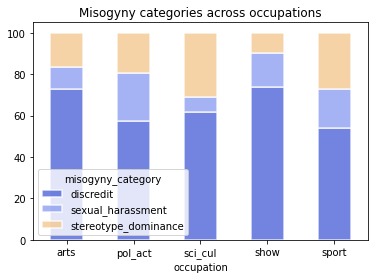

In [ ]:
df_plot = LABELED_TWEETS['misogyny_category'].groupby(LABELED_TWEETS['occupation']).value_counts(normalize = True).unstack(1) * 100
df_plot.plot(kind = 'bar', stacked = True, color = ['#4f65d9','#8f9ff1', '#f3c890'], alpha=0.8, edgecolor='white', linewidth=1.5)
plt.xticks(rotation=0)
plt.title('Misogyny categories across occupations')


## Clustering on labled new data-set

In [ ]:
# transform labeled texts into vectors
# apply cosine similarity and k medodis

#see if the clusters are well differentiated with respect to occupations
#see the label of the most representative medoid

In [ ]:
from sklearn_extra.cluster import KMedoids

from sklearn.metrics import silhouette_score
from numpy import dot
from numpy.linalg import norm

def cosine_similarity_calc(a,b):
	cos_sim = dot(a, b)/(norm(a)*norm(b))
	
	return cos_sim

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
labeled_tweets___ = [normalizeTweet(i) for i in LABELED_TWEETS['text']]
embeddings = model.encode(labeled_tweets___)

In [ ]:
kmedoids = KMedoids(n_clusters=10, random_state=42 , metric = cosine_similarity_calc)
kmedoids.fit(embeddings)

/usr/local/lib/python3.8/dist-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 6 is empty! self.labels_[self.medoid_indices_[6]] may not be labeled with its corresponding cluster (6).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 9 is empty! self.labels_[self.medoid_indices_[9]] may not be labeled with its corresponding cluster (9).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 8 is empty! self.labels_[self.medoid_indices_[8]] may not be labeled with its corresponding cluster (8).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn_extra/cluster/_k_medoids.py:243: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


KMedoids(metric=<function cosine_similarity_calc at 0x7f7e06b3cc10>,
         n_clusters=10, random_state=42)

In [ ]:
LABELED_TWEETS

,Unnamed: 0,text,occupation,misogyny_category,cluster_labels
0,0,@SarahhWaqar @CallmeJaagii Bitch shut the fuck up,arts,stereotype_dominance,0
1,1,RT @bnixole: bitch shut the fuck up you're fuc...,arts,stereotype_dominance,1
2,2,@AnisaJomha ice has more talent in his ejecula...,sport,sexual_harassment,1
3,3,@ArianasBotch Ok if you fucking said leave blo...,show,sexual_harassment,1
4,4,@LadyNadiaEssex Shut the fuck up ye little slag,show,stereotype_dominance,1
...,...,...,...,...,...
964,964,@USER your a slut,sport,discredit,1
965,965,@USER But youve been fat for years .,sport,stereotype_dominance,0
966,966,@USER FAT you ...,sport,discredit,0
967,967,@USER Look how fat you are . Youve obviously h...,sport,stereotype_dominance,0


In [ ]:
LABELED_TWEETS['cluster_labels'] = kmedoids.labels_

Text(0.5, 1.0, 'Misogyny categories across clusters')

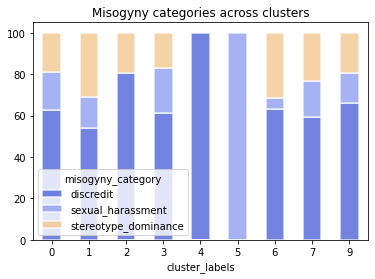

In [ ]:
bar_pl = LABELED_TWEETS['misogyny_category'].groupby(LABELED_TWEETS['cluster_labels']).value_counts(normalize=True).unstack(1)*100
bar_pl.plot(kind='bar', stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5,color = ['#4f65d9','#8f9ff1', '#f3c890'] )

plt.xticks(rotation=0)
plt.title('Misogyny categories across clusters')

Text(0.5, 1.0, 'Occupations across clusters')

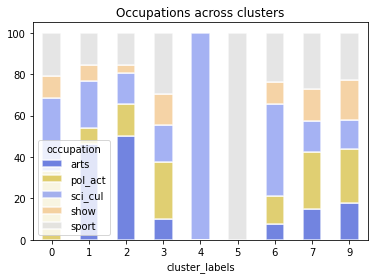

In [ ]:
bar_pl = LABELED_TWEETS['occupation'].groupby(LABELED_TWEETS['cluster_labels']).value_counts(normalize=True).unstack(1) * 100
bar_pl.plot(kind='bar', stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5, color =['#4f65d9','#d9c34f','#8f9ff1', '#f3c890', '#dfdfdf'])
plt.xticks(rotation=0)
plt.title('Occupations across clusters')

In [ ]:
center_4 = kmedoids.cluster_centers_[4]
center_5 = kmedoids.cluster_centers_[5]

In [ ]:
c=0
for em in embeddings:
  if list(em) == list(center_4):
    print(c)
    break

  c=c+1
LABELED_TWEETS['text'].iloc[c]

662


'Artists are nothing more than whores from the Soros They are those mediocre , petty and vain types who only find fame after prostituting themselves . This must be the cause of their overuse of drugs : to support themselves @USER @USER @USER @USER HTTPURL'

In [ ]:
c=0
for em in embeddings:
  if list(em) == list(center_5):
    print(c)
    break

  c=c+1
LABELED_TWEETS['text'].iloc[c]

56


'#WomenAgainstFeminism #SomebodyToTris #MensHealth The #feminists are running scared. Men are fighting #feminism. http://t.co/DapbomSQnA'